In [1]:
pip install pandas numpy seaborn matplotlib tensorflow sklearn xgboost

     |████████████████████████████████| 9.5 MB 3.6 MB/s eta 0:00:01
     |████████████████████████████████| 285 kB 35.7 MB/s eta 0:00:01
     |████████████████████████████████| 11.5 MB 35.2 MB/s eta 0:00:01
     |████████████████████████████████| 25.9 MB 307 kB/s  eta 0:00:01
     |████████████████████████████████| 3.0 MB 3.4 MB/s eta 0:00:01
     |████████████████████████████████| 1.1 MB 30.6 MB/s eta 0:00:01
     |████████████████████████████████| 22.2 MB 30.1 MB/s eta 0:00:01
     |████████████████████████████████| 303 kB 31.0 MB/s eta 0:00:01
  Created wheel for sklearn: filename=sklearn-0.0-py2.py3-none-any.whl size=1316 sha256=9459fc1553d369cd83a28d378c87c6df9f9f0c88b46ada893ca336edf874a217
  Stored in directory: /root/.cache/pip/wheels/23/9d/42/5ec745cbbb17517000a53cecc49d6a865450d1f5cb16dc8a9c
Successfully built sklearn
You should consider upgrading via the '/usr/bin/python3 -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import StratifiedKFold

import string
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 42

In [3]:
def concat_df(train_data, test_data):
    # Returns a concatenated df of training and test set
    return pd.concat([train_data, test_data], sort = True).reset_index(drop=True)

def divide_df(all_data):
    # Returns divided dfs of training and test set
    return all_data.loc[:890], all_data.loc[891:].drop(['Survived'], axis=1)

df_train = pd.read_csv(r'train.csv')
df_test = pd.read_csv(r'test.csv')
df_all = concat_df(df_train, df_test)

df_train.name = 'Training Set'
df_test.name = 'Test Set'
df_all.name = 'All Set'

dfs = [df_train, df_test]

print('Number of Training Examples = {}'.format(df_train.shape[0]))
print('Number of Test Examples = {}\n'.format(df_test.shape[0]))
print('Training X Shape = {}'.format(df_train.shape))
print('Training y Shape = {}\n'.format(df_train['Survived'].shape[0]))
print('Test X Shape = {}'.format(df_test.shape))
print('Test y Shape = {}'.format(df_test.shape[0]))
print(df_train.columns)
print(df_test.columns)

Number of Training Examples = 891
Number of Test Examples = 418

Training X Shape = (891, 12)
Training y Shape = 891

Test X Shape = (418, 11)
Test y Shape = 418
Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')
Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')


# Exploration

In [4]:
print(df_train.info())
df_train.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
474,475,0,3,"Strandberg, Miss. Ida Sofia",female,22.0,0,0,7553,9.8375,NaN,S
436,437,0,3,"Ford, Miss. Doolina Margaret ""Daisy""",female,21.0,2,2,W./C. 6608,34.3750,NaN,S
191,192,0,2,"Carbines, Mr. William",male,19.0,0,0,28424,13.0000,NaN,S


In [5]:
print(df_test.info())
df_test.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB
None


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
182,1074,1,"Marvin, Mrs. Daniel Warner (Mary Graham Carmic...",female,18.0,1,0,113773,53.1000,D30,S
284,1176,3,"Rosblom, Miss. Salli Helena",female,2.0,1,1,370129,20.2125,NaN,S
175,1067,2,"Brown, Miss. Edith Eileen",female,15.0,0,2,29750,39.0000,NaN,S


### Missing Values

In [6]:
def display_missing(df):
    for col in df.columns.tolist():
        print('{} column missing values: {}'.format(col,df[col].isnull().sum()))
    print('\n')
    
for df in dfs:
    print('{}'.format(df.name))
    display_missing(df)

Training Set
PassengerId column missing values: 0
Survived column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 177
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 0
Cabin column missing values: 687
Embarked column missing values: 2


Test Set
PassengerId column missing values: 0
Pclass column missing values: 0
Name column missing values: 0
Sex column missing values: 0
Age column missing values: 86
SibSp column missing values: 0
Parch column missing values: 0
Ticket column missing values: 0
Fare column missing values: 1
Cabin column missing values: 327
Embarked column missing values: 0




In [7]:
df_all_corr = df_all.corr().abs().unstack().sort_values(kind='quicksort',ascending=False).reset_index()
df_all_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace = True)
df_all_corr[df_all_corr['Feature 1'] == 'Age']

,Feature 1,Feature 2,Correlation Coefficient
6,Age,Age,1.000000
9,Age,Pclass,0.408106
17,Age,SibSp,0.243699
22,Age,Fare,0.178740
25,Age,Parch,0.150917
29,Age,Survived,0.077221
41,Age,PassengerId,0.028814


#### Age

In [8]:
age_by_pclass_sex = df_all.groupby(['Sex', 'Pclass']).median()['Age']

for pclass in range(1, 4):
    for sex in ['female', 'male']:
        print('Median age of Pclass {} {}s: {}'.format(pclass, sex, age_by_pclass_sex[sex][pclass]))
print('Median age of all passengers: {}'.format(df_all['Age'].median()))

# Filling the missing values in Age with the medians of Sex and Pclass groups
df_all['Age'] = df_all.groupby(['Sex', 'Pclass'])['Age'].apply(lambda x: x.fillna(x.median()))

Median age of Pclass 1 females: 36.0
Median age of Pclass 1 males: 42.0
Median age of Pclass 2 females: 28.0
Median age of Pclass 2 males: 29.5
Median age of Pclass 3 females: 22.0
Median age of Pclass 3 males: 25.0
Median age of all passengers: 28.0


#### Embarked

In [9]:
# Filling the missing values in Embarked with S, found online
df_all['Embarked'] = df_all['Embarked'].fillna('S')

#### Fare

In [10]:
med_fare = df_all.groupby(['Pclass', 'Parch', 'SibSp']).Fare.median()[3][0][0]
# Filling the missing value in Fare with the median Fare of 3rd class alone passenger
df_all['Fare'] = df_all['Fare'].fillna(med_fare)

#### Cabin

In [11]:
# Creating Deck column from the first letter of the Cabin column (M stands for Missing)
df_all['Deck'] = df_all['Cabin'].apply(lambda s: s[0] if pd.notnull(s) else 'M')

df_all_decks = df_all.groupby(['Deck', 'Pclass']).count().drop(columns=['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name': 'Count'}).transpose()

In [12]:
def get_pclass_dist(df):
    # Creating a dictionary for every passenger class count in every deck
    deck_counts = {'A': {}, 'B': {}, 'C': {}, 'D': {}, 'E': {}, 'F': {}, 'G': {}, 'M': {}, 'T': {}}
    decks = df.columns.levels[0]
    
    for deck in decks:
        for pclass in range(1,4):
            try:
                count = df[deck][pclass][0]
                deck_counts[deck][pclass] = count
            except KeyError:
                deck_counts[deck][pclass] = 0
    
    df_decks = pd.DataFrame(deck_counts)
    deck_percentages = {}
    
    # Creating a dictionary for every passenger class percentage in every deck
    for col in df_decks.columns:
        deck_percentages[col] = [(count / df_decks[col].sum()) * 100 for count in df_decks[col]]
        
    return deck_counts, deck_percentages

In [13]:
def display_pclass_dist(percentages):
    
    df_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T')
    bar_count = np.arange(len(deck_names))
    bar_width = 0.85
    
    pclass1 = df_percentages[0]
    pclass2 = df_percentages[1]
    pclass3 = df_percentages[2]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, pclass1, color='#b5ffb9', edgecolor='white', width=bar_width, label='Passenger Class 1')
    plt.bar(bar_count, pclass2, bottom=pclass1, color='#f9bc86', edgecolor='white', width=bar_width, label='Passenger Class 2')
    plt.bar(bar_count, pclass3, bottom=pclass1 + pclass2, color='#a3acff', edgecolor='white', width=bar_width, label='Passenger Class 3')

    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Passenger Class Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Passenger Class Distribution in Decks', size=18, y=1.05)   
    
    plt.show()

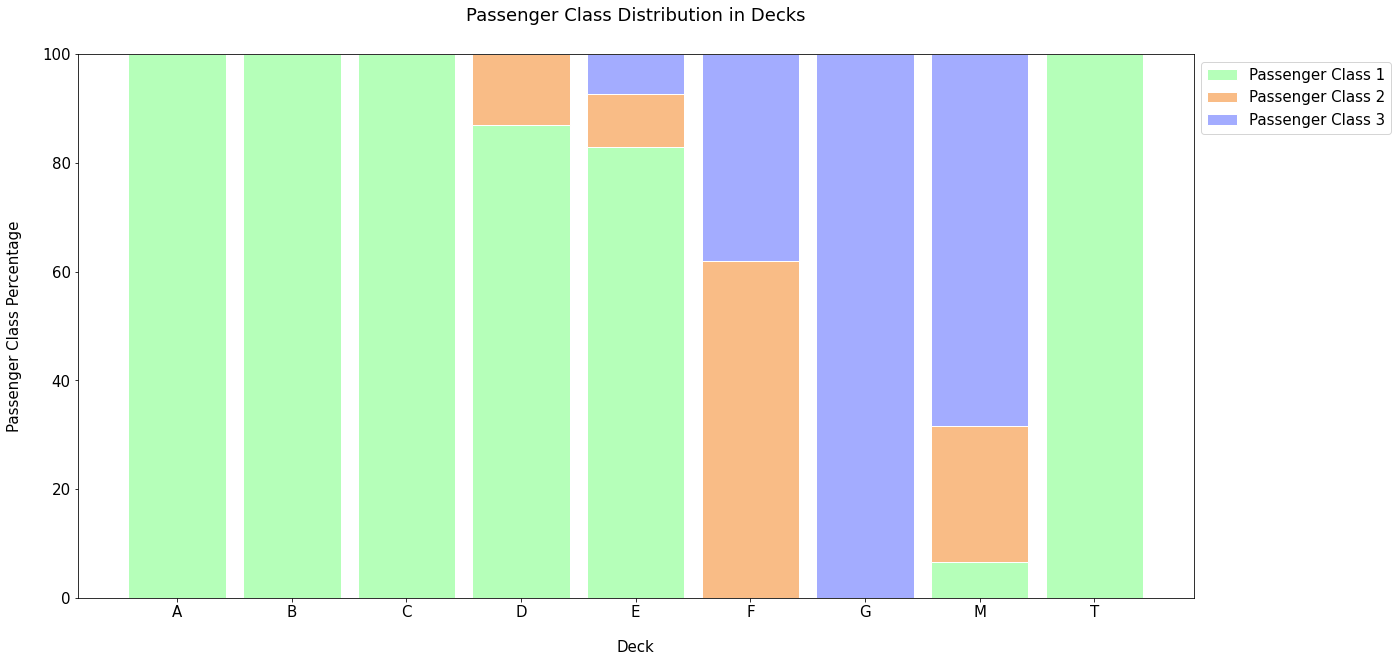

In [14]:
all_deck_count, all_deck_per = get_pclass_dist(df_all_decks)
display_pclass_dist(all_deck_per)

In [15]:
# Passenger in the T deck is changed to A
idx = df_all[df_all['Deck'] == 'T'].index
df_all.loc[idx, 'Deck'] = 'A'

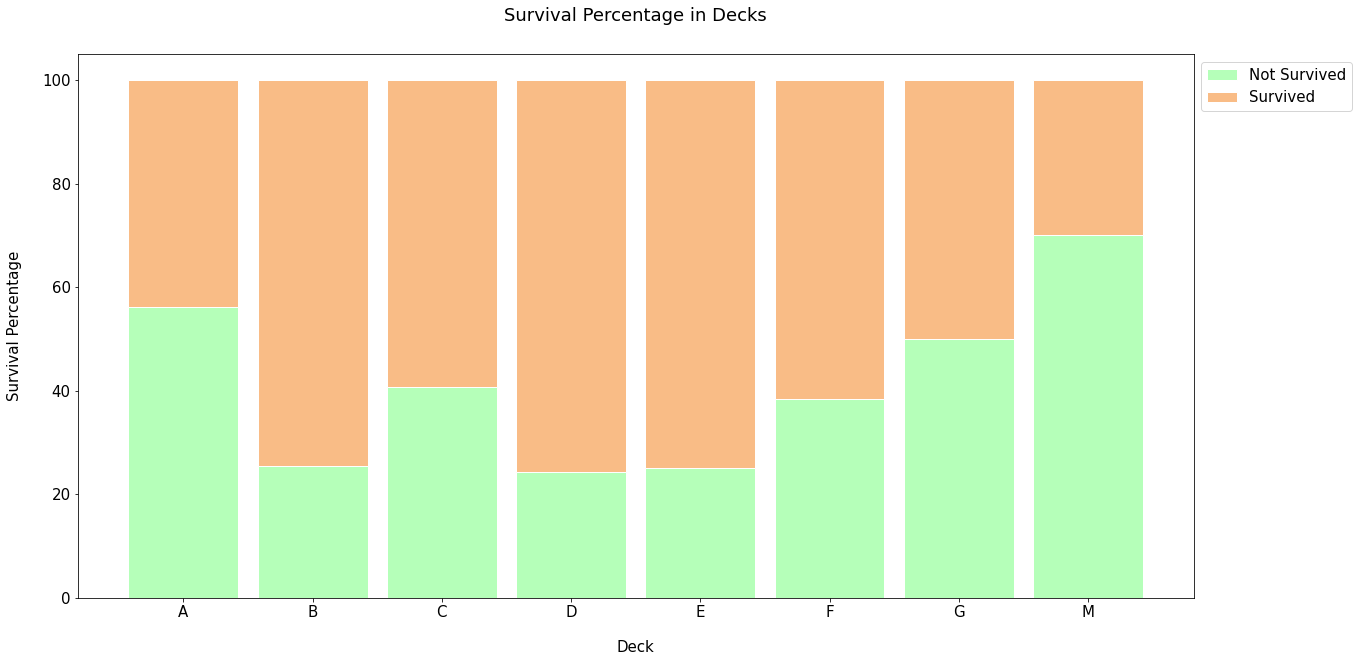

In [16]:
df_all_decks_survived = df_all.groupby(['Deck', 'Survived']).count().drop(columns=['Sex', 'Age', 'SibSp', 'Parch', 'Fare', 
                                                                                   'Embarked', 'Pclass', 'Cabin', 'PassengerId', 'Ticket']).rename(columns={'Name':'Count'}).transpose()

def get_survived_dist(df):
    
    # Creating a dictionary for every survival count in every deck
    surv_counts = {'A':{}, 'B':{}, 'C':{}, 'D':{}, 'E':{}, 'F':{}, 'G':{}, 'M':{}}
    decks = df.columns.levels[0]    

    for deck in decks:
        for survive in range(0, 2):
            surv_counts[deck][survive] = df[deck][survive][0]
            
    df_surv = pd.DataFrame(surv_counts)
    surv_percentages = {}

    for col in df_surv.columns:
        surv_percentages[col] = [(count / df_surv[col].sum()) * 100 for count in df_surv[col]]
        
    return surv_counts, surv_percentages

def display_surv_dist(percentages):
    
    df_survived_percentages = pd.DataFrame(percentages).transpose()
    deck_names = ('A', 'B', 'C', 'D', 'E', 'F', 'G', 'M')
    bar_count = np.arange(len(deck_names))  
    bar_width = 0.85    

    not_survived = df_survived_percentages[0]
    survived = df_survived_percentages[1]
    
    plt.figure(figsize=(20, 10))
    plt.bar(bar_count, not_survived, color='#b5ffb9', edgecolor='white', width=bar_width, label="Not Survived")
    plt.bar(bar_count, survived, bottom=not_survived, color='#f9bc86', edgecolor='white', width=bar_width, label="Survived")
 
    plt.xlabel('Deck', size=15, labelpad=20)
    plt.ylabel('Survival Percentage', size=15, labelpad=20)
    plt.xticks(bar_count, deck_names)    
    plt.tick_params(axis='x', labelsize=15)
    plt.tick_params(axis='y', labelsize=15)
    
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1), prop={'size': 15})
    plt.title('Survival Percentage in Decks', size=18, y=1.05)
    
    plt.show()

all_surv_count, all_surv_per = get_survived_dist(df_all_decks_survived)
display_surv_dist(all_surv_per)

In [17]:
df_all['Deck'] = df_all['Deck'].replace(['A', 'B', 'C'], 'ABC')
df_all['Deck'] = df_all['Deck'].replace(['D', 'E'], 'DE')
df_all['Deck'] = df_all['Deck'].replace(['F', 'G'], 'FG')

df_all['Deck'].value_counts()

M      1014
ABC     182
DE       87
FG       26
Name: Deck, dtype: int64

In [18]:
df_all.drop(['Cabin'], inplace = True, axis=1)

df_train, df_test = divide_df(df_all)
dfs = [df_train, df_test]

for df in dfs:
    display_missing(df)

Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Survived column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0


Age column missing values: 0
Embarked column missing values: 0
Fare column missing values: 0
Name column missing values: 0
Parch column missing values: 0
PassengerId column missing values: 0
Pclass column missing values: 0
Sex column missing values: 0
SibSp column missing values: 0
Ticket column missing values: 0
Deck column missing values: 0




342 of 891 passengers survived and it is the 38.38% of the training set.
549 of 891 passengers didnt survive and it is the 61.62% of the training set.


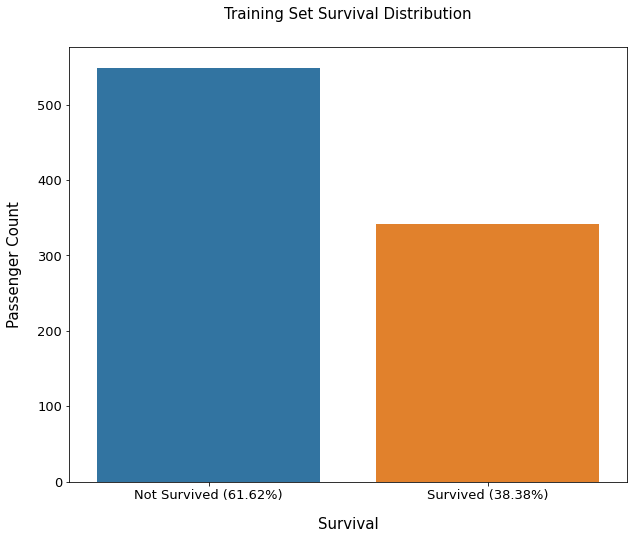

In [19]:
survived = df_train['Survived'].value_counts()[1]
not_survived = df_train['Survived'].value_counts()[0]
survived_per = survived / df_train.shape[0] * 100
not_survived_per = not_survived / df_train.shape[0] * 100

print('{} of {} passengers survived and it is the {:.2f}% of the training set.'.format(survived, df_train.shape[0], survived_per))
print('{} of {} passengers didnt survive and it is the {:.2f}% of the training set.'.format(not_survived, df_train.shape[0], not_survived_per))

plt.figure(figsize=(10, 8))
sns.countplot(df_train['Survived'])

plt.xlabel('Survival', size=15, labelpad=15)
plt.ylabel('Passenger Count', size=15, labelpad=15)
plt.xticks((0, 1), ['Not Survived ({0:.2f}%)'.format(not_survived_per), 'Survived ({0:.2f}%)'.format(survived_per)])
plt.tick_params(axis='x', labelsize=13)
plt.tick_params(axis='y', labelsize=13)

plt.title('Training Set Survival Distribution', size=15, y=1.05)

plt.show()

### Correlations

In [20]:
df_train_corr = df_train.drop(['PassengerId'], axis=1).corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_train_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_train_corr.drop(df_train_corr.iloc[1::2].index, inplace=True)
df_train_corr_nd = df_train_corr.drop(df_train_corr[df_train_corr['Correlation Coefficient'] == 1.0].index)

df_test_corr = df_test.corr().abs().unstack().sort_values(kind="quicksort", ascending=False).reset_index()
df_test_corr.rename(columns={"level_0": "Feature 1", "level_1": "Feature 2", 0: 'Correlation Coefficient'}, inplace=True)
df_test_corr.drop(df_test_corr.iloc[1::2].index, inplace=True)
df_test_corr_nd = df_test_corr.drop(df_test_corr[df_test_corr['Correlation Coefficient'] == 1.0].index)

In [21]:
# Training set high correlations
corr = df_train_corr_nd['Correlation Coefficient'] > 0.1
df_train_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Pclass,Fare,0.549500
8,Pclass,Age,0.417667
10,SibSp,Parch,0.414838
12,Survived,Pclass,0.338481
14,Survived,Fare,0.257307
16,SibSp,Age,0.249747
18,Parch,Fare,0.216225
20,Age,Parch,0.176733
22,SibSp,Fare,0.159651
24,Age,Fare,0.124061


In [22]:
# Test set high correlations
corr = df_test_corr_nd['Correlation Coefficient'] > 0.1
df_test_corr_nd[corr]

,Feature 1,Feature 2,Correlation Coefficient
6,Fare,Pclass,0.577489
8,Age,Pclass,0.526789
10,Age,Fare,0.345347
12,SibSp,Parch,0.306895
14,Fare,Parch,0.230410
16,SibSp,Fare,0.172032


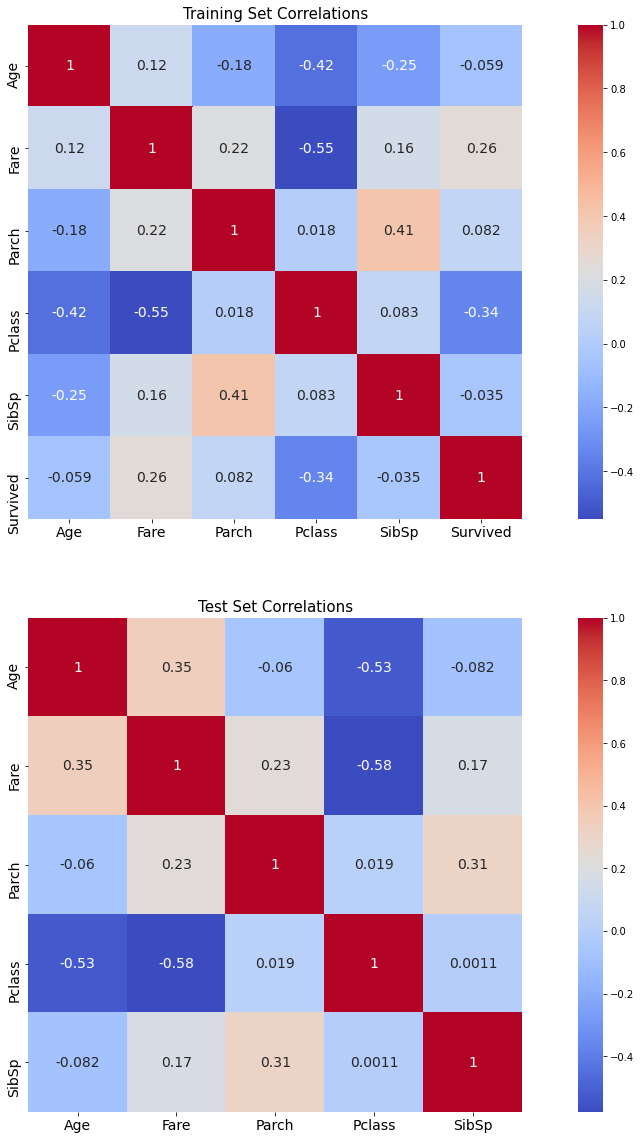

In [23]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))

sns.heatmap(df_train.drop(['PassengerId'], axis=1).corr(), ax=axs[0], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})
sns.heatmap(df_test.drop(['PassengerId'], axis=1).corr(), ax=axs[1], annot=True, square=True, cmap='coolwarm', annot_kws={'size': 14})

for i in range(2):    
    axs[i].tick_params(axis='x', labelsize=14)
    axs[i].tick_params(axis='y', labelsize=14)
    
axs[0].set_title('Training Set Correlations', size=15)
axs[1].set_title('Test Set Correlations', size=15)

plt.show()

### Continuous Features

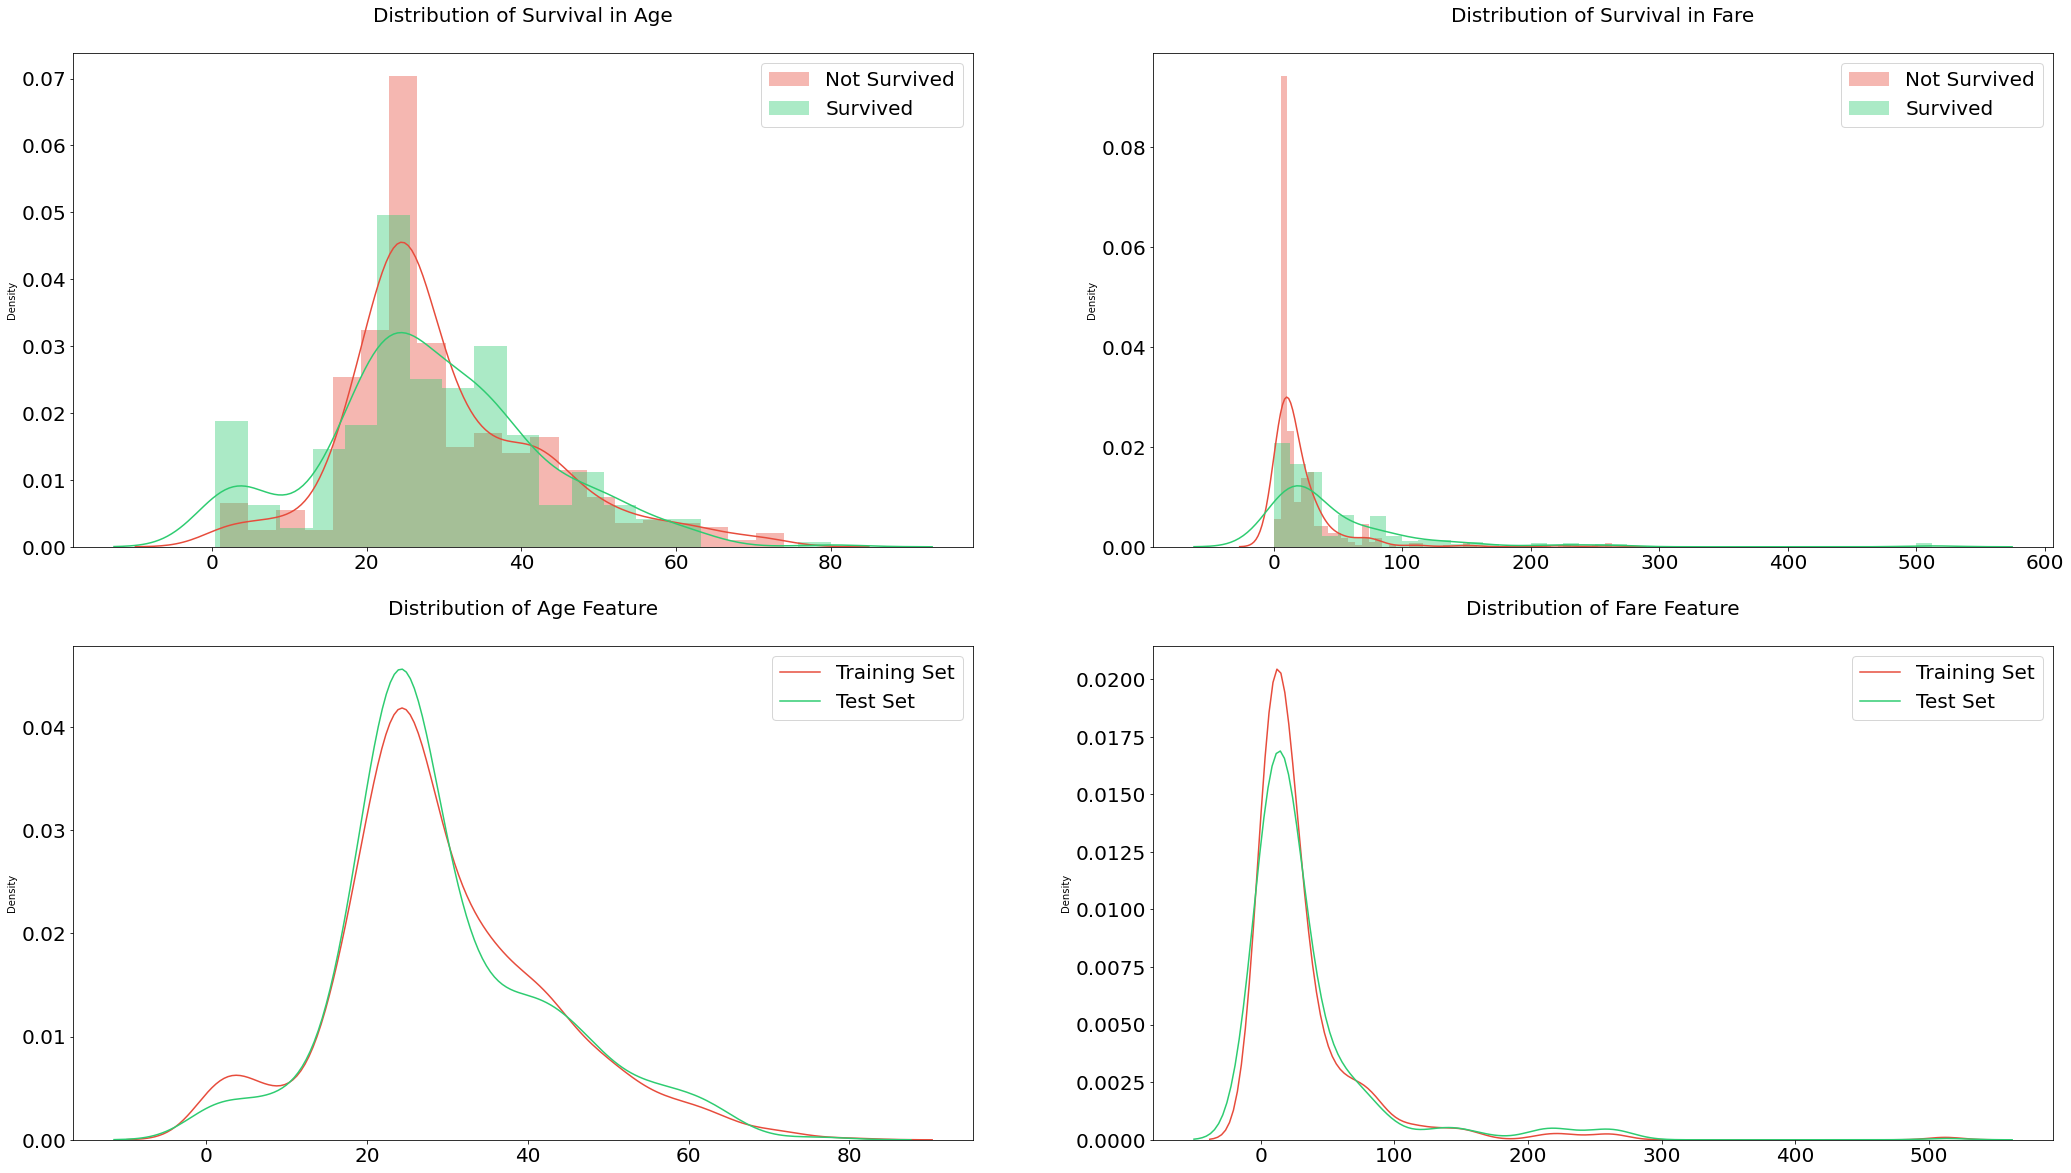

In [24]:
cont_features = ['Age', 'Fare']
surv = df_train['Survived'] == 1

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(20, 20))
plt.subplots_adjust(right=1.5)

for i, feature in enumerate(cont_features):    
    # Distribution of survival in feature
    sns.distplot(df_train[~surv][feature], label='Not Survived', hist=True, color='#e74c3c', ax=axs[0][i])
    sns.distplot(df_train[surv][feature], label='Survived', hist=True, color='#2ecc71', ax=axs[0][i])
    
    # Distribution of feature in dataset
    sns.distplot(df_train[feature], label='Training Set', hist=False, color='#e74c3c', ax=axs[1][i])
    sns.distplot(df_test[feature], label='Test Set', hist=False, color='#2ecc71', ax=axs[1][i])
    
    axs[0][i].set_xlabel('')
    axs[1][i].set_xlabel('')
    
    for j in range(2):        
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
    
    axs[0][i].legend(loc='upper right', prop={'size': 20})
    axs[1][i].legend(loc='upper right', prop={'size': 20})
    axs[0][i].set_title('Distribution of Survival in {}'.format(feature), size=20, y=1.05)

axs[1][0].set_title('Distribution of {} Feature'.format('Age'), size=20, y=1.05)
axs[1][1].set_title('Distribution of {} Feature'.format('Fare'), size=20, y=1.05)
        
plt.show()

### Categorical Features

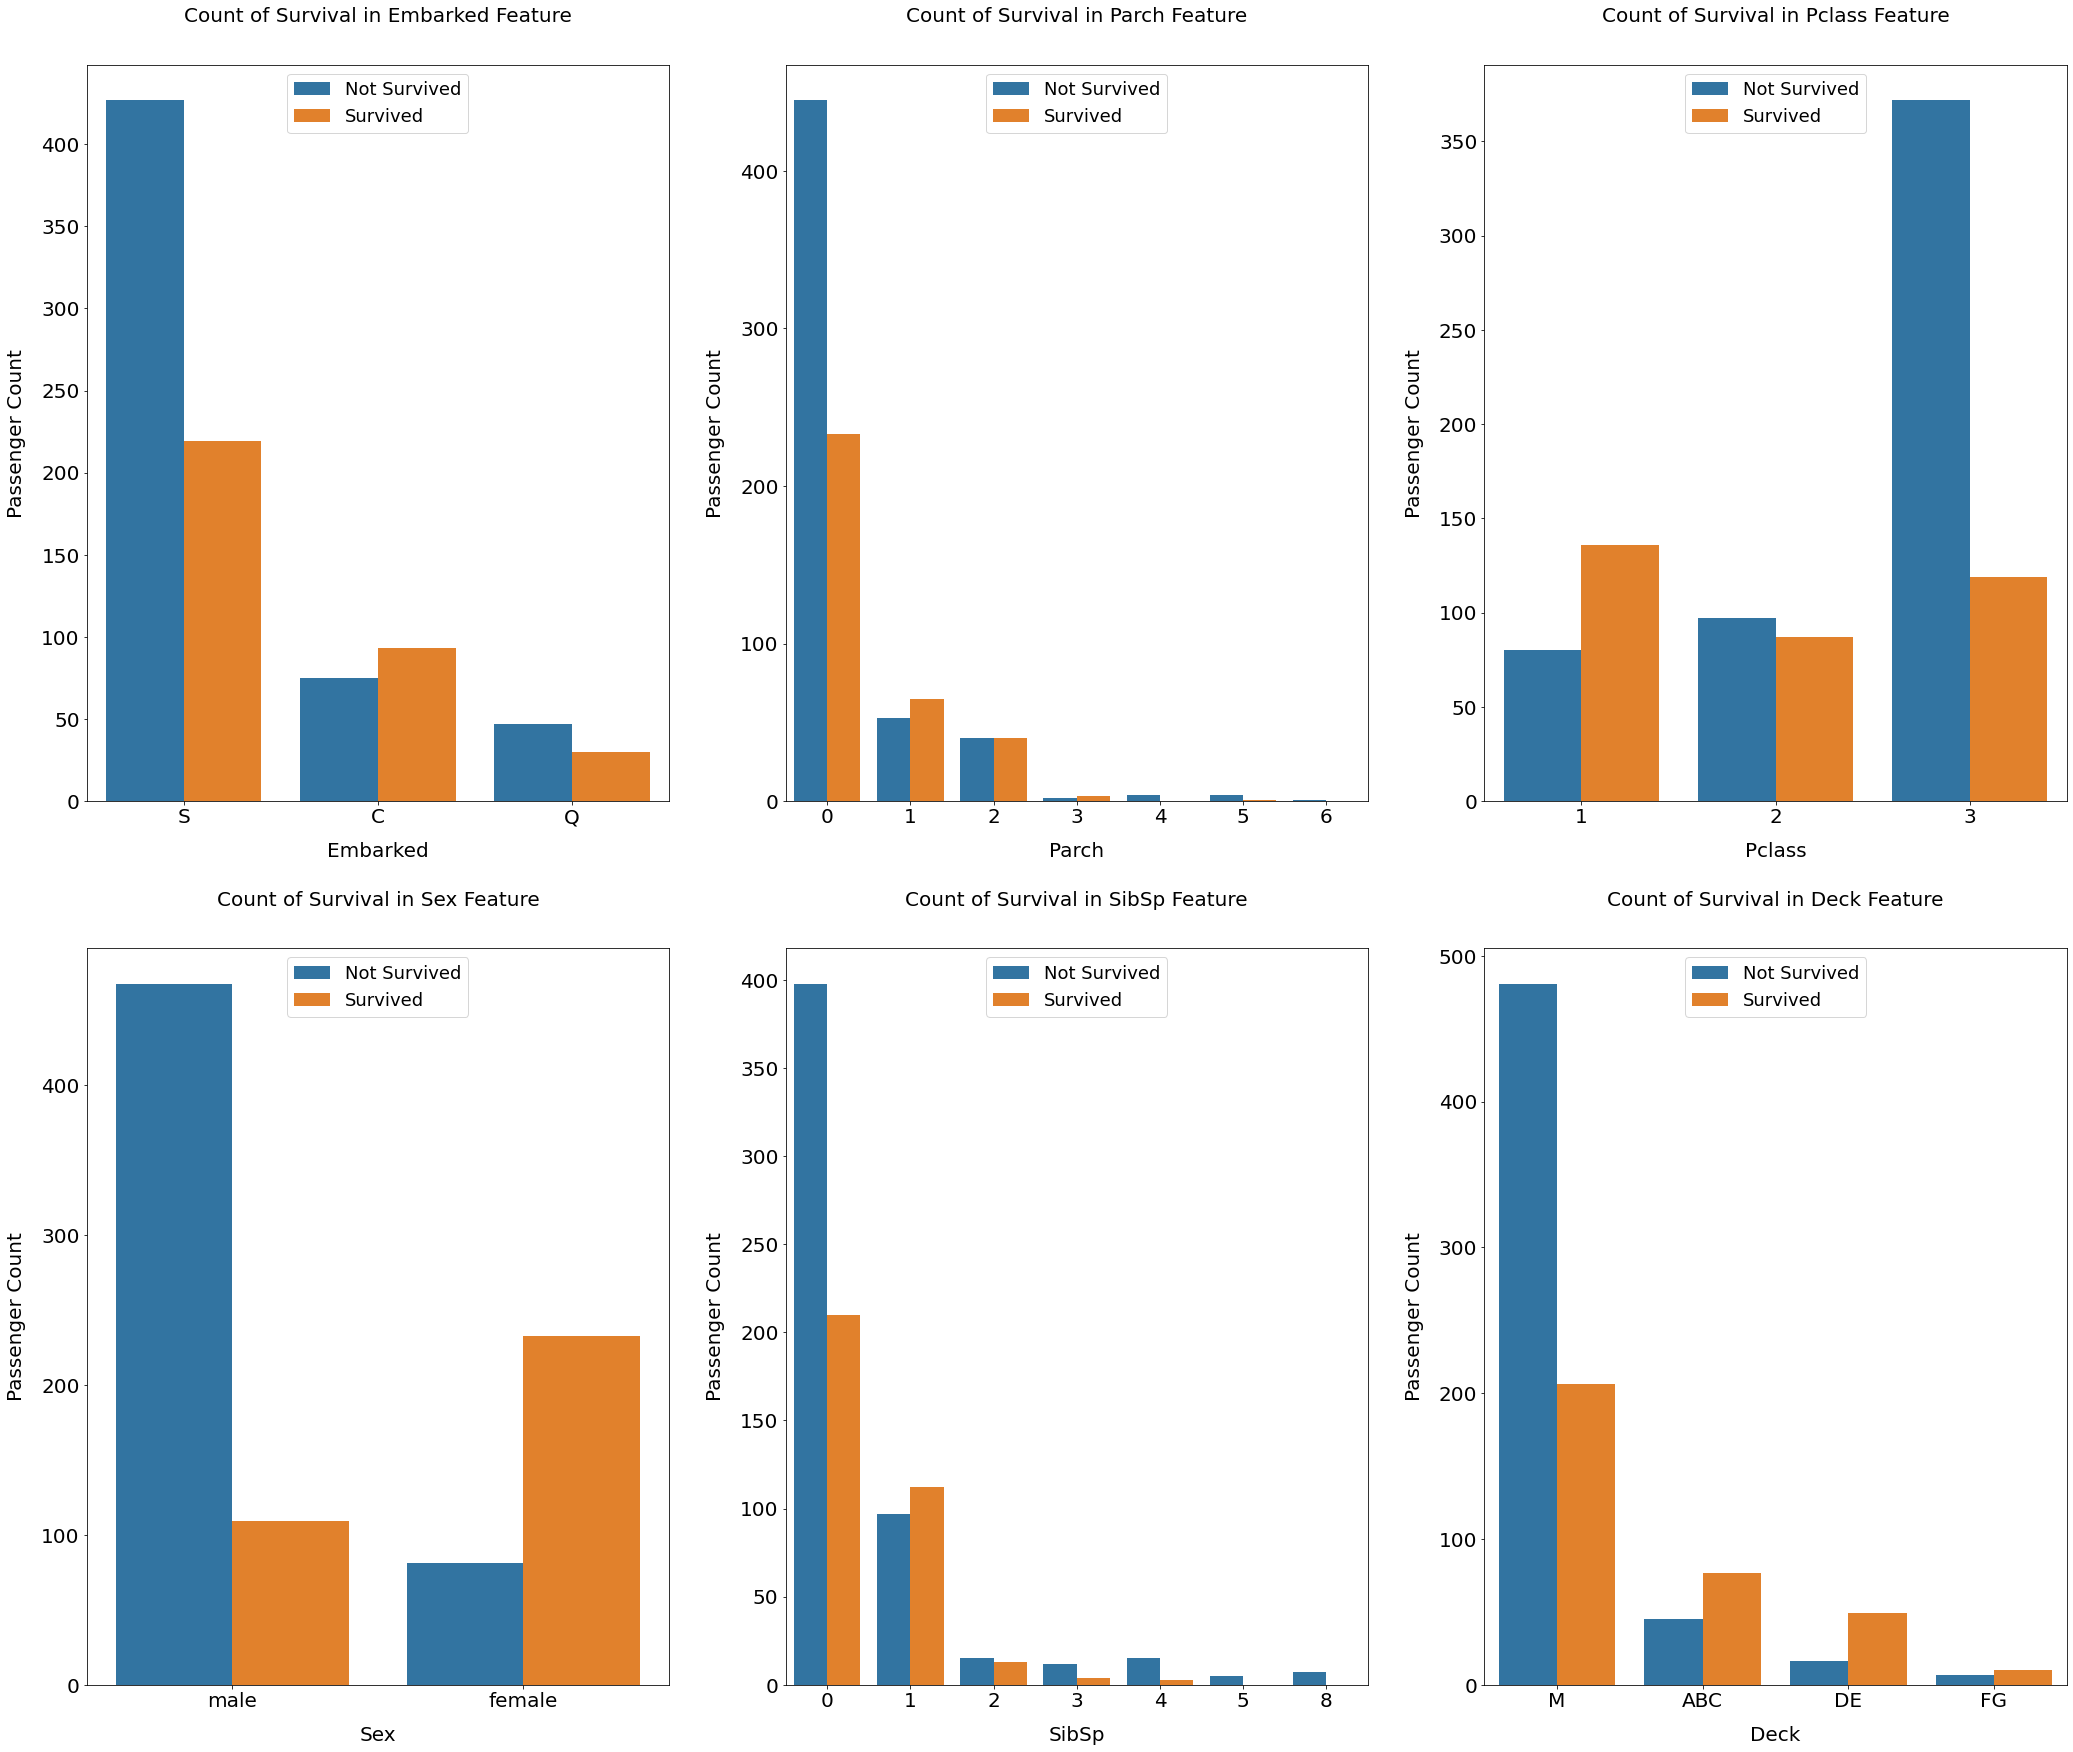

In [25]:
cat_features = ['Embarked', 'Parch', 'Pclass', 'Sex', 'SibSp', 'Deck']

fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))
plt.subplots_adjust(right=1.5, top=1.25)

for i, feature in enumerate(cat_features, 1):    
    plt.subplot(2, 3, i)
    sns.countplot(x=feature, hue='Survived', data=df_train)
    
    plt.xlabel('{}'.format(feature), size=20, labelpad=15)
    plt.ylabel('Passenger Count', size=20, labelpad=15)    
    plt.tick_params(axis='x', labelsize=20)
    plt.tick_params(axis='y', labelsize=20)
    
    plt.legend(['Not Survived', 'Survived'], loc='upper center', prop={'size': 18})
    plt.title('Count of Survival in {} Feature'.format(feature), size=20, y=1.05)

plt.show()

### Conclusion

- Features are correlated, need feature engineering
- Split points and spikes are visible in continuous variables
- Vary distinct surival rates per categorical variable, one-hot encode or combine to create new features

# Feature Engineering

In [26]:
df_all = concat_df(df_train, df_test)
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,M,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,ABC,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,M,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,ABC,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,M,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


## Binning Continuous Features

### Fare

In [27]:
# positively skewed and surivavl rate is high on the right end
# use quantile based bins, even though a lot of bins, provide decent info gain

df_all['Fare'] = pd.qcut(df_all['Fare'], 13)

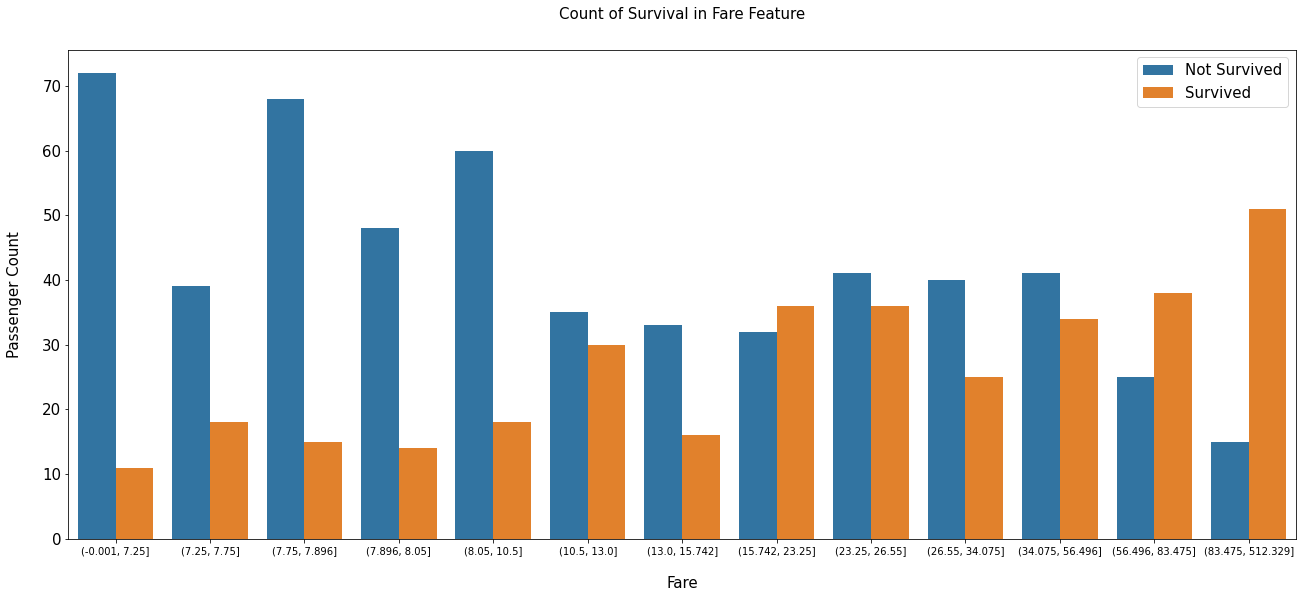

In [28]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Fare', hue='Survived', data=df_all)

plt.xlabel('Fare', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=10)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Fare'), size=15, y=1.05)

plt.show()

### Age

In [29]:
df_all['Age'] = pd.qcut(df_all['Age'], 10)

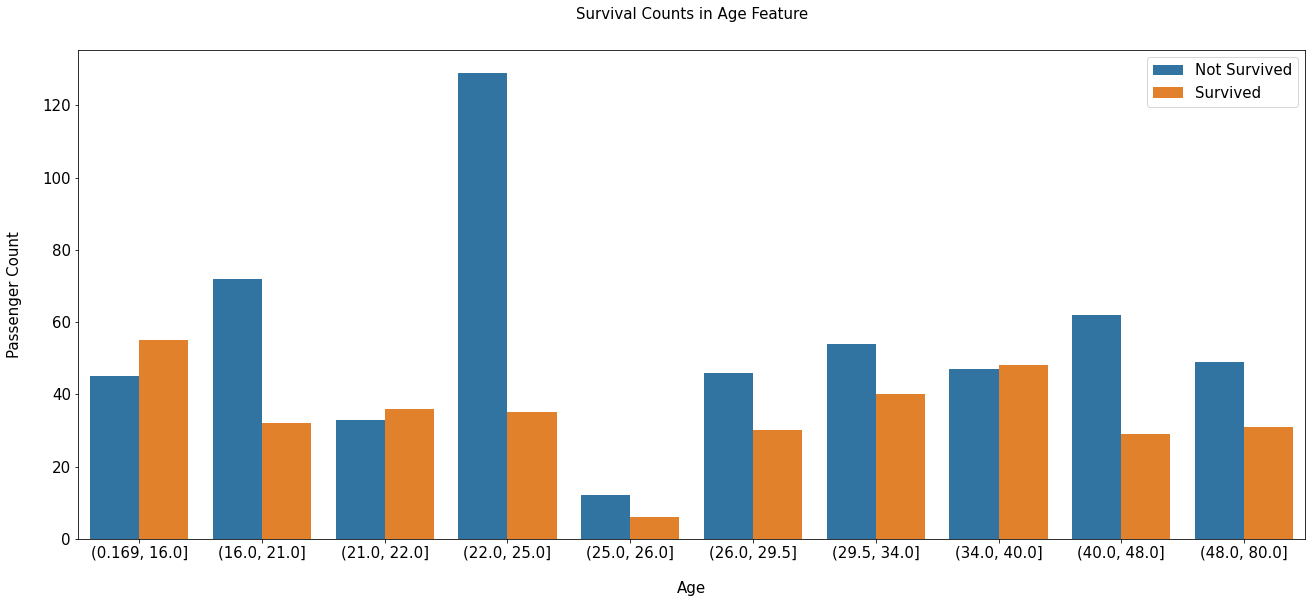

In [30]:
fig, axs = plt.subplots(figsize=(22, 9))
sns.countplot(x='Age', hue='Survived', data=df_all)

plt.xlabel('Age', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Survival Counts in {} Feature'.format('Age'), size=15, y=1.05)

plt.show()

## Frequency Encoding

#### Family_Size created by SibSp + Parch + 1 (current passenger)

- Family Size with 1 are labeled as Alone
- Family Size with 2, 3 and 4 are labeled as Small
- Family Size with 5 and 6 are labeled as Medium
- Family Size with 7, 8 and 11 are labeled as Large

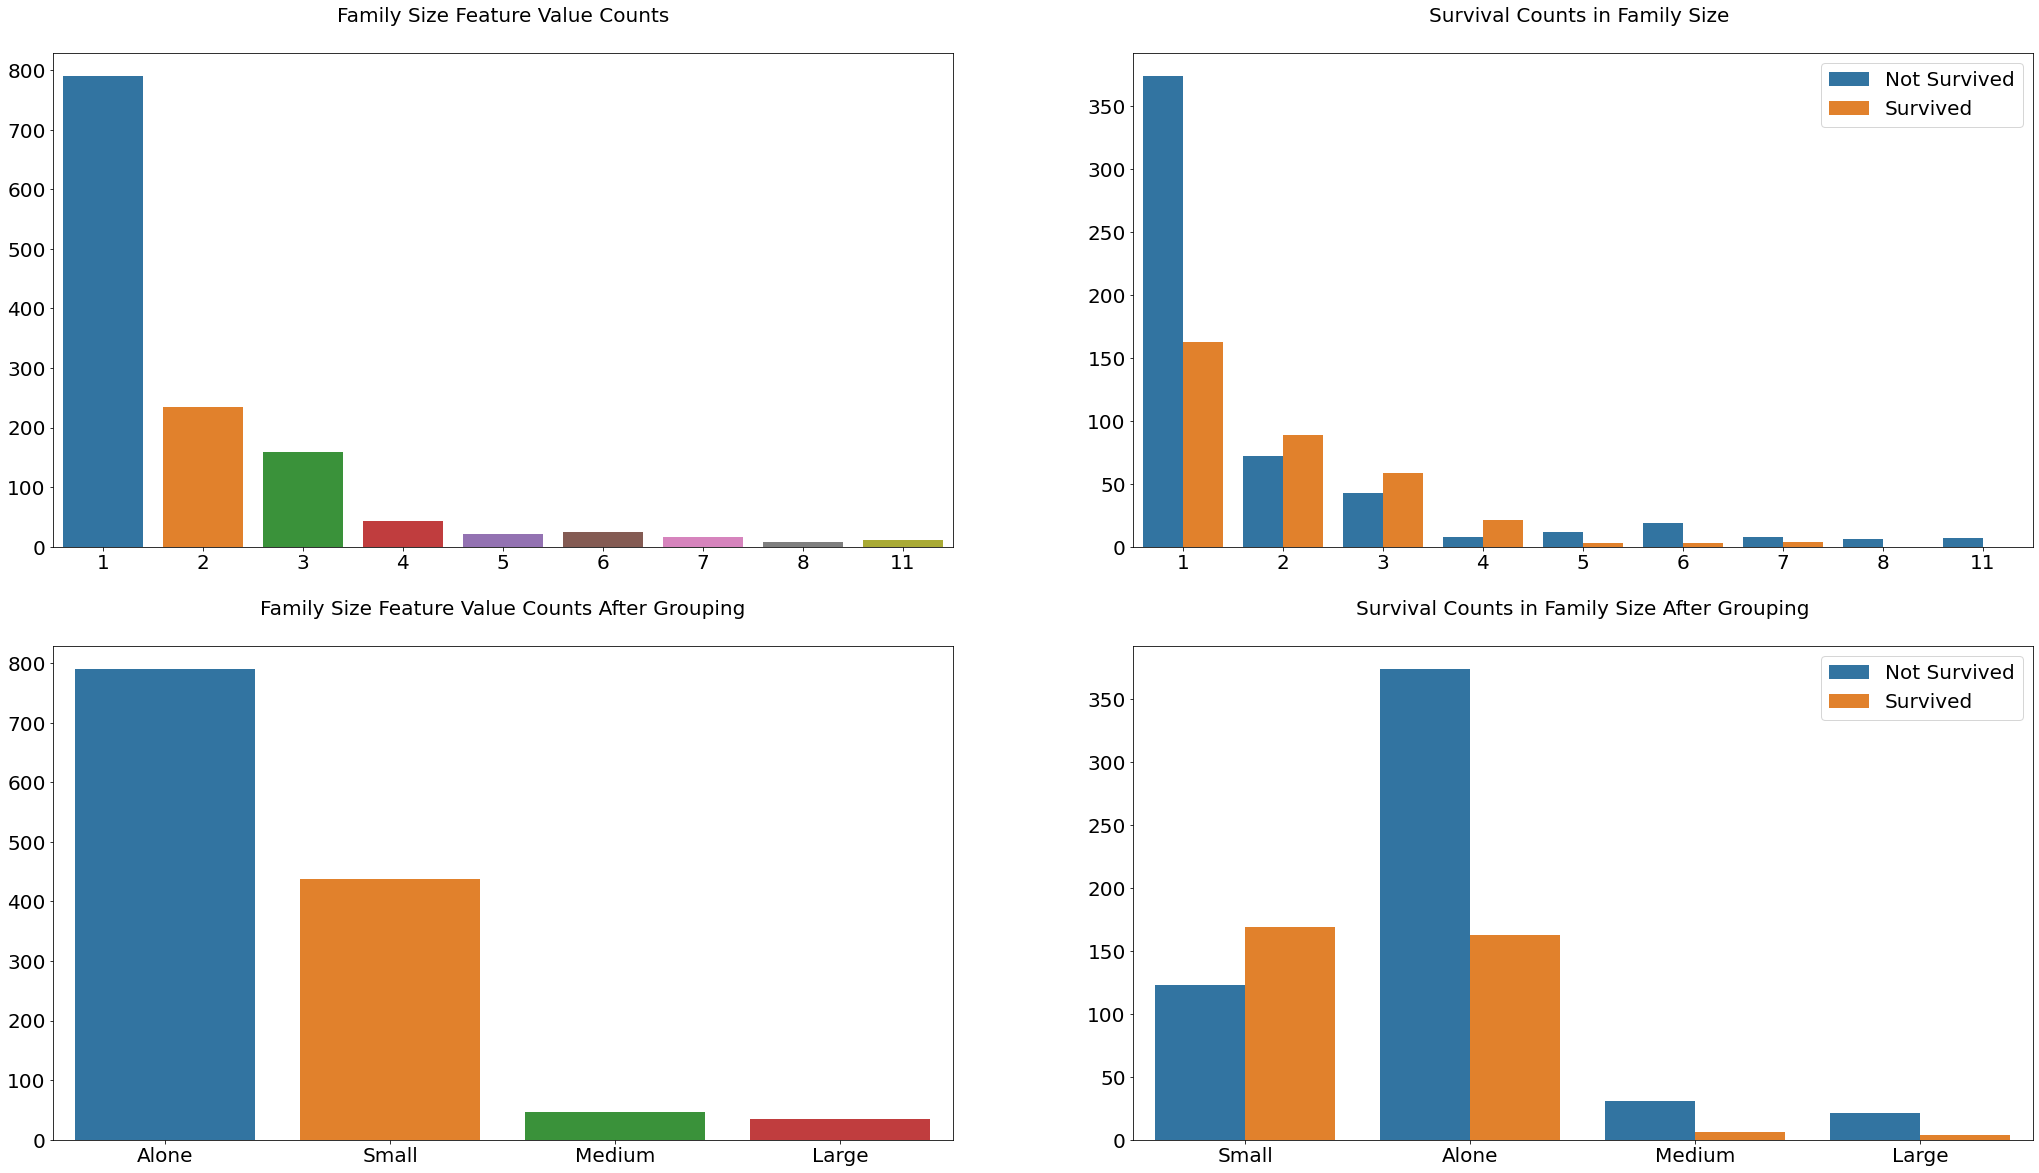

In [31]:
df_all['Family_Size'] = df_all['SibSp'] + df_all['Parch'] + 1

fig, axs = plt.subplots(figsize=(20, 20), ncols=2, nrows=2)
plt.subplots_adjust(right=1.5)

sns.barplot(x=df_all['Family_Size'].value_counts().index, y=df_all['Family_Size'].value_counts().values, ax=axs[0][0])
sns.countplot(x='Family_Size', hue='Survived', data=df_all, ax=axs[0][1])

axs[0][0].set_title('Family Size Feature Value Counts', size=20, y=1.05)
axs[0][1].set_title('Survival Counts in Family Size ', size=20, y=1.05)

family_map = {1: 'Alone', 2: 'Small', 3: 'Small', 4: 'Small', 5: 'Medium', 6: 'Medium', 7: 'Large', 8: 'Large', 11: 'Large'}
df_all['Family_Size_Grouped'] = df_all['Family_Size'].map(family_map)

sns.barplot(x=df_all['Family_Size_Grouped'].value_counts().index, y=df_all['Family_Size_Grouped'].value_counts().values, ax=axs[1][0])
sns.countplot(x='Family_Size_Grouped', hue='Survived', data=df_all, ax=axs[1][1])

axs[1][0].set_title('Family Size Feature Value Counts After Grouping', size=20, y=1.05)
axs[1][1].set_title('Survival Counts in Family Size After Grouping', size=20, y=1.05)

for i in range(2):
    axs[i][1].legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 20})
    for j in range(2):
        axs[i][j].tick_params(axis='x', labelsize=20)
        axs[i][j].tick_params(axis='y', labelsize=20)
        axs[i][j].set_xlabel('')
        axs[i][j].set_ylabel('')

plt.show()

### Ticket Frequency

In [32]:
df_all.head()

,Age,Deck,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket,Family_Size,Family_Size_Grouped
0,"(21.0, 22.0]",M,S,"(-0.001, 7.25]","Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171,2,Small
1,"(34.0, 40.0]",ABC,C,"(56.496, 83.475]","Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599,2,Small
2,"(25.0, 26.0]",M,S,"(7.896, 8.05]","Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282,1,Alone
3,"(34.0, 40.0]",ABC,S,"(34.075, 56.496]","Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803,2,Small
4,"(34.0, 40.0]",M,S,"(7.896, 8.05]","Allen, Mr. William Henry",0,5,3,male,0,0.0,373450,1,Alone


In [33]:
 df_all['Ticket_Frequency'] = df_all.groupby('Ticket')['Ticket'].transform('count')

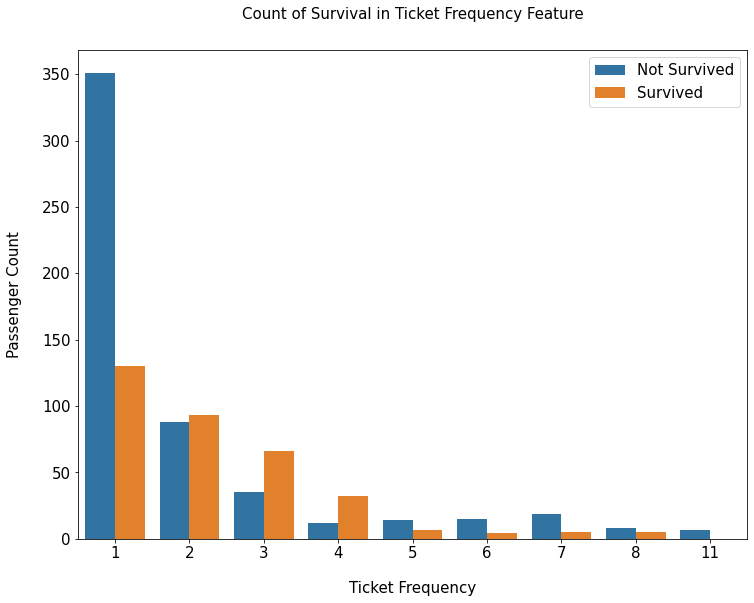

In [34]:
fig, axs = plt.subplots(figsize=(12, 9))
sns.countplot(x='Ticket_Frequency', hue='Survived', data=df_all)

plt.xlabel('Ticket Frequency', size=15, labelpad=20)
plt.ylabel('Passenger Count', size=15, labelpad=20)
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)

plt.legend(['Not Survived', 'Survived'], loc='upper right', prop={'size': 15})
plt.title('Count of Survival in {} Feature'.format('Ticket Frequency'), size=15, y=1.05)

plt.show()

### Title & is Married

In [35]:
#extract prefix before Name

df_all['Title'] = df_all['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
df_all['Is_Married'] = 0
df_all['Is_Married'].loc[df_all['Title'] == 'Mrs'] = 1

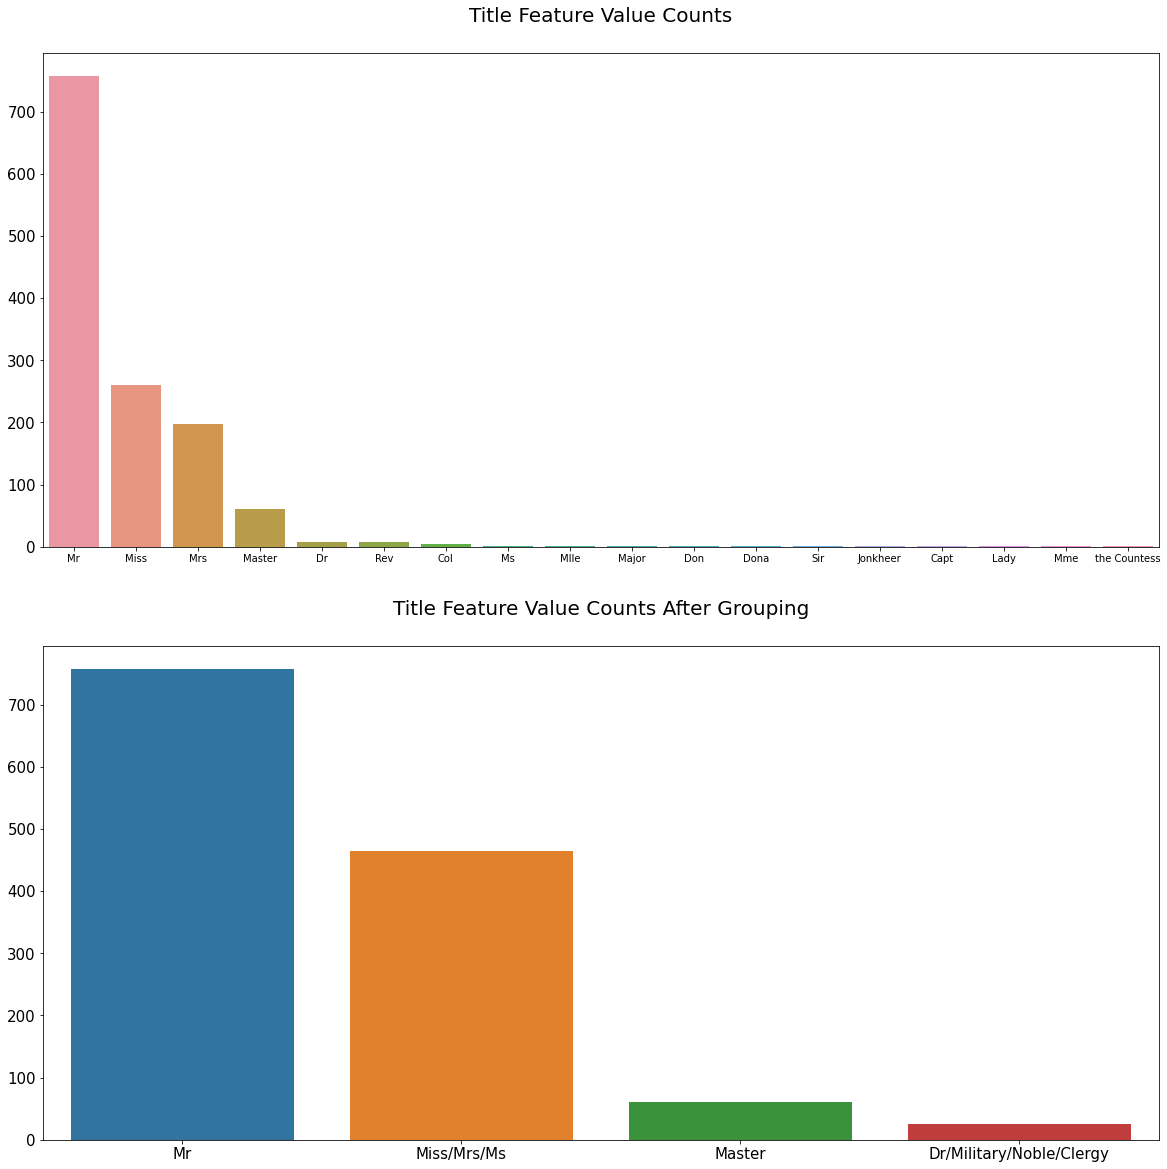

In [36]:
fig, axs = plt.subplots(nrows=2, figsize=(20, 20))
sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[0])

axs[0].tick_params(axis='x', labelsize=10)
axs[1].tick_params(axis='x', labelsize=15)

for i in range(2):    
    axs[i].tick_params(axis='y', labelsize=15)

axs[0].set_title('Title Feature Value Counts', size=20, y=1.05)

df_all['Title'] = df_all['Title'].replace(['Miss', 'Mrs','Ms', 'Mlle', 'Lady', 'Mme', 'the Countess', 'Dona'], 'Miss/Mrs/Ms')
df_all['Title'] = df_all['Title'].replace(['Dr', 'Col', 'Major', 'Jonkheer', 'Capt', 'Sir', 'Don', 'Rev'], 'Dr/Military/Noble/Clergy')

sns.barplot(x=df_all['Title'].value_counts().index, y=df_all['Title'].value_counts().values, ax=axs[1])
axs[1].set_title('Title Feature Value Counts After Grouping', size=20, y=1.05)

plt.show()

## Target Encoding

### Extract Surname

In [37]:
def extract_surname(data):
    
    families = []
    
    for i in range(len(data)):
        name = data.iloc[i]
        
        if '(' in name:
            name_no_bracket = name.split('(')[0]
        else:
            name_no_bracket = name
        
        family = name_no_bracket.split(',')[0]
        title = name_no_bracket.split(',')[1].strip().split(' ')[0]
        
        for c in string.punctuation:
            family = family.replace(c, '').strip()
        
        families.append(family)
    
    return families

df_all['Family'] = extract_surname(df_all['Name'])
df_train = df_all.loc[:890]
df_test = df_all.loc[891:]
dfs = [df_train, df_test]

## Feature Transformation

In [38]:
non_numeric_features = ['Embarked', 'Sex', 'Deck', 'Title', 'Family_Size_Grouped', 'Age', 'Fare']

for df in dfs:
    for feature in non_numeric_features:        
        df[feature] = LabelEncoder().fit_transform(df[feature])

### One-Hot Encoding the Categorical Features

In [39]:
cat_features = ['Pclass', 'Sex', 'Deck', 'Embarked', 'Title', 'Family_Size_Grouped']
encoded_features = []

for df in dfs:
    for feature in cat_features:
        encoded_feat = OneHotEncoder().fit_transform(df[feature].values.reshape(-1, 1)).toarray()
        n = df[feature].nunique()
        cols = ['{}_{}'.format(feature, n) for n in range(1, n + 1)]
        encoded_df = pd.DataFrame(encoded_feat, columns=cols)
        encoded_df.index = df.index
        encoded_features.append(encoded_df)

df_train = pd.concat([df_train, *encoded_features[:6]], axis=1)
df_test = pd.concat([df_test, *encoded_features[6:]], axis=1)

In [40]:
df_all = concat_df(df_train, df_test)
drop_cols = ['Deck', 'Embarked', 'Family', 'Family_Size', 'Family_Size_Grouped', 'Survived',
             'Name', 'Parch', 'PassengerId', 'Pclass', 'Sex', 'SibSp', 'Ticket', 'Title']

df_all.drop(columns=drop_cols, inplace=True)

df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,...,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,1.0,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,1.0,0.0,1.0,1,0.0,0.0,0.0,1.0


## Model

In [55]:
pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

import warnings
warnings.filterwarnings("ignore")

In [42]:
df_all.head()

,Age,Deck_1,Deck_2,Deck_3,Deck_4,Embarked_1,Embarked_2,Embarked_3,Family_Size_Grouped_1,Family_Size_Grouped_2,Family_Size_Grouped_3,Family_Size_Grouped_4,Fare,Is_Married,Pclass_1,Pclass_2,Pclass_3,Sex_1,Sex_2,Ticket_Frequency,Title_1,Title_2,Title_3,Title_4
0,2,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,0,0.0,0.0,1.0,0.0,1.0,1,0.0,0.0,0.0,1.0
1,7,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,11,1,1.0,0.0,0.0,1.0,0.0,2,0.0,0.0,1.0,0.0
2,4,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,0,0.0,0.0,1.0,1.0,0.0,1,0.0,0.0,1.0,0.0
3,7,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,10,1,1.0,0.0,0.0,1.0,0.0,2,0.0,0.0,1.0,0.0
4,7,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3,0,0.0,0.0,1.0,0.0,1.0,1,0.0,0.0,0.0,1.0


In [43]:
df_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Age                    1309 non-null   int64  
 1   Deck_1                 1309 non-null   float64
 2   Deck_2                 1309 non-null   float64
 3   Deck_3                 1309 non-null   float64
 4   Deck_4                 1309 non-null   float64
 5   Embarked_1             1309 non-null   float64
 6   Embarked_2             1309 non-null   float64
 7   Embarked_3             1309 non-null   float64
 8   Family_Size_Grouped_1  1309 non-null   float64
 9   Family_Size_Grouped_2  1309 non-null   float64
 10  Family_Size_Grouped_3  1309 non-null   float64
 11  Family_Size_Grouped_4  1309 non-null   float64
 12  Fare                   1309 non-null   int64  
 13  Is_Married             1309 non-null   int64  
 14  Pclass_1               1309 non-null   float64
 15  Pcla

In [59]:
X = df_train.drop(columns=drop_cols)
y = df_train.Survived

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [60]:
# Logistic Regression
lr = LogisticRegression(solver='liblinear')
lr.fit(X_train, y_train)
y_pred = lr.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8268156424581006


In [61]:
# Random Forests
random_forest = RandomForestClassifier(n_estimators=100)
random_forest.fit(X_train, y_train)
y_pred = random_forest.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8379888268156425


In [62]:
# KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 3)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8100558659217877


In [63]:
# GaussianNB
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_pred = gaussian.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8044692737430168


In [64]:
# Support vector machine
svc = SVC()
svc.fit(X_train, y_train)
y_pred = svc.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8044692737430168


#### Stacking Ensemble ML Model

In [65]:
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.ensemble import StackingClassifier

In [66]:
def get_stacking():
    """
    Return 
    ----------------
    Stack model  
    """
    level0 = list()  # First layer
    level0.append(('lr',LogisticRegression(solver='liblinear')))
    level0.append(('RF',RandomForestClassifier()))
    level0.append(('GB',GaussianNB()))

    level1 = LogisticRegression(solver='liblinear') #Second layer
    
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
    return model

In [67]:
def evaluate_model(model,X,y):
    """
    Return
    -----------
    Return accracy score that perform base on Cross Validation
    """
    cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(np.mean(scores))
    return scores

In [68]:
scores = evaluate_model(get_stacking(), X, y)

0.8249063670411985


#### Hyper Tune Each Model

In [69]:
# define Folds
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

In [70]:
lr = LogisticRegression()
# define search space
space = dict()
space['solver'] = ['newton-cg', 'lbfgs', 'liblinear']
space['penalty'] = ['none', 'l1', 'l2', 'elasticnet']
space['C'] = [0.001,0.01,0.1,1,10,100]
# define search
search = RandomizedSearchCV(lr, space, n_iter=500, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X, y)

# Score print
print('Best Score of LogisticRegression: %s' % result.best_score_)
print('Best Hyperparameters of LogisticRegression: %s' % result.best_params_)

Best Score of LogisticRegression: 0.8252840374113363
Best Hyperparameters of LogisticRegression: {'solver': 'lbfgs', 'penalty': 'l2', 'C': 1}


In [71]:
rf = RandomForestClassifier()
# define search space
space = dict()
space['n_estimators'] = [10, 50, 100, 300, 1000]
space['max_features'] = ['sqrt', 'log2']
space['max_depth'] = [10, 20, 60, 100]

# define search
search = RandomizedSearchCV(rf, space, n_iter=10, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X, y)

# Score print
print('Best Score of RandomForestClassifier: %s' % result.best_score_)
print('Best Hyperparameters of RandomForestClassifier: %s' % result.best_params_)

Best Score of RandomForestClassifier: 0.8200447764316948
Best Hyperparameters of RandomForestClassifier: {'n_estimators': 100, 'max_features': 'sqrt', 'max_depth': 10}


In [72]:
GB = GaussianNB()
# define search space
space = dict()
space['var_smoothing'] = np.logspace(0,-9, num=100)
# define search
search = RandomizedSearchCV(GB, space, n_iter=20, scoring='accuracy', n_jobs=-1, cv=cv, random_state=1)
# execute search
result = search.fit(X, y)

# Score print
print('Best Score of GaussianNB: %s' % result.best_score_)
print('Best Hyperparameters of GaussianNB: %s' % result.best_params_)

Best Score of GaussianNB: 0.8110727512397214
Best Hyperparameters of GaussianNB: {'var_smoothing': 0.0015199110829529332}


In [73]:
def get_stacking():
    level0 = list()
    level0.append(('lr',LogisticRegression(solver= 'liblinear', penalty= 'l2', C=1)))
    level0.append(('RF',RandomForestClassifier(n_estimators=300, max_features='sqrt', max_depth= 10)))
    level0.append(('GB',GaussianNB(var_smoothing= 1.23e-06)))
    
    level1 = RandomForestClassifier(n_estimators=300, max_features='sqrt', max_depth= 10)
    
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5,stack_method='predict')
    return model

In [74]:
def evaluate_model(model,X,y):
    cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(np.mean(scores))
    return scores
final_model = get_stacking()
scores = evaluate_model(final_model, X, y)

0.8219237126775887


In [75]:
level0 = list()
level0.append(('lr',LogisticRegression(solver= 'newton-cg', penalty= 'l2', C=10)))
level0.append(('RF',RandomForestClassifier(n_estimators=300, max_features='sqrt', max_depth= 10)))
level0.append(('GB',GaussianNB(var_smoothing= 8.1e-08)))

level1 = GaussianNB(var_smoothing= 8.1e-08)

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5,stack_method='predict')
model.fit(X,y).score(X,y)

0.8484848484848485

Add some more advance models

In [78]:
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier

In [79]:
# GradientBoosting
gbc = GradientBoostingClassifier().fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8324022346368715


In [80]:
# XGBoost
xgbc = XGBClassifier(verbosity = 0).fit(X_train, y_train)
y_pred = gbc.predict(X_test)
print(accuracy_score(y_test,y_pred))

0.8324022346368715


In [81]:
def get_stacking():
    level0 = list()
    level0.append(('lr',LogisticRegression(solver= 'liblinear', penalty= 'l2', C=1)))
    level0.append(('RF',RandomForestClassifier(n_estimators=300, max_features='sqrt', max_depth= 10)))
    level0.append(('GB',GaussianNB(var_smoothing= 1.23e-06)))
    level0.append(('gbc',GradientBoostingClassifier()))
    level0.append(('xgbc',XGBClassifier()))
    
    level1 = LogisticRegression()
    
    model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5,stack_method='predict')
    return model

In [82]:
def evaluate_model(model,X,y):
    cv = RepeatedStratifiedKFold(n_splits=2, n_repeats=1, random_state=1)
    scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
    print(np.mean(scores))
    return scores
final_model = get_stacking()
scores = evaluate_model(final_model, X, y)

0.8226835289968257


In [83]:
level0 = list()
level0.append(('lr',LogisticRegression(solver= 'liblinear', penalty= 'l2', C=1)))
level0.append(('RF',RandomForestClassifier(n_estimators=300, max_features='sqrt', max_depth= 10)))
level0.append(('GB',GaussianNB(var_smoothing= 1.23e-06)))
level0.append(('gbc',GradientBoostingClassifier()))
level0.append(('xgbc',XGBClassifier(verbosity = 0)))

level1 = LogisticRegression(solver= 'liblinear')

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5,stack_method='predict')
model.fit(X,y).score(X,y)

0.8787878787878788

In [84]:
leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

In [85]:
level0 = list()
level0.append(('lr',LogisticRegression(solver= 'liblinear', penalty= 'l2', C=1)))
level0.append(('RF',RandomForestClassifier(n_estimators=300, max_features='sqrt', max_depth= 10)))
level0.append(('GB',GaussianNB(var_smoothing= 1.23e-06)))
level0.append(('gbc',GradientBoostingClassifier()))
level0.append(('xgbc',XGBClassifier(verbosity = 0)))
level0.append(('strong_RF',leaderboard_model))

level1 = LogisticRegression(solver= 'liblinear')

model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5,stack_method='predict')
model.fit(X,y).score(X,y)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:    0.9s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done 312 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 1743 out of 1750 | elapsed:    1.2s remaining:    0.0s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    1.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=-1)]: Using backend 

0.8799102132435466

In [44]:
# Running a different setup
X_train = StandardScaler().fit_transform(df_train.drop(columns = drop_cols))
y_train = df_train['Survived'].values
X_test = StandardScaler().fit_transform(df_test.drop(columns=drop_cols))

print('X_train shape: {}'.format(X_train.shape))
print('y_train shape: {}'.format(y_train.shape))
print('X_test shape: {}'.format(X_test.shape))

X_train shape: (891, 24)
y_train shape: (891,)
X_test shape: (418, 24)


### Random Forest

In [46]:
single_best_model = RandomForestClassifier(criterion='gini', 
                                           n_estimators=1100,
                                           max_depth=5,
                                           min_samples_split=4,
                                           min_samples_leaf=5,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1)

In [47]:
leaderboard_model = RandomForestClassifier(criterion='gini',
                                           n_estimators=1750,
                                           max_depth=7,
                                           min_samples_split=6,
                                           min_samples_leaf=6,
                                           max_features='auto',
                                           oob_score=True,
                                           random_state=SEED,
                                           n_jobs=-1,
                                           verbose=1) 

In [48]:
N = 5
oob = 0
probs = pd.DataFrame(np.zeros((len(X_test), N * 2)), columns=['Fold_{}_Prob_{}'.format(i, j) for i in range(1, N + 1) for j in range(2)])
importances = pd.DataFrame(np.zeros((X_train.shape[1], N)), columns=['Fold_{}'.format(i) for i in range(1, N + 1)], index=df_all.columns)
fprs, tprs, scores = [], [], []

skf = StratifiedKFold(n_splits=N, random_state=N, shuffle=True)

In [51]:
for fold, (trn_idx, val_idx) in enumerate(skf.split(X_train, y_train), 1):
    print('Fold {}\n'.format(fold))
    
    # Fitting the model
    leaderboard_model.fit(X_train[trn_idx], y_train[trn_idx])
    
    # Computing Train AUC score
    trn_fpr, trn_tpr, trn_thresholds = roc_curve(y_train[trn_idx], leaderboard_model.predict_proba(X_train[trn_idx])[:, 1])
    trn_auc_score = auc(trn_fpr, trn_tpr)
    # Computing Validation AUC score
    val_fpr, val_tpr, val_thresholds = roc_curve(y_train[val_idx], leaderboard_model.predict_proba(X_train[val_idx])[:, 1])
    val_auc_score = auc(val_fpr, val_tpr)  
      
    scores.append((trn_auc_score, val_auc_score))
    fprs.append(val_fpr)
    tprs.append(val_tpr)
    
    # X_test probabilities
    probs.loc[:, 'Fold_{}_Prob_0'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 0]
    probs.loc[:, 'Fold_{}_Prob_1'.format(fold)] = leaderboard_model.predict_proba(X_test)[:, 1]
    importances.iloc[:, fold - 1] = leaderboard_model.feature_importances_
        
    oob += leaderboard_model.oob_score_ / N
    print('Fold {} OOB Score: {}\n'.format(fold, leaderboard_model.oob_score_))   
    
print('Average OOB Score: {}'.format(oob))

Fold 1



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 1 OOB Score: 0.8426966292134831

Fold 2



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 2 OOB Score: 0.8274894810659187

Fold 3



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.2s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 3 OOB Score: 0.8373071528751753

Fold 4



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 4 OOB Score: 0.8190743338008415

Fold 5



[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 792 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1242 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done 1750 out of 1750 | elapsed:    2.4s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 442 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 792 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1242 tasks      | elapsed:    0.2s
[Parallel(n_jobs=4)]: Done 1750 out of 1750 | elapsed:    0.3s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent worker

Fold 5 OOB Score: 0.8190743338008415

Average OOB Score: 0.8291283861512521


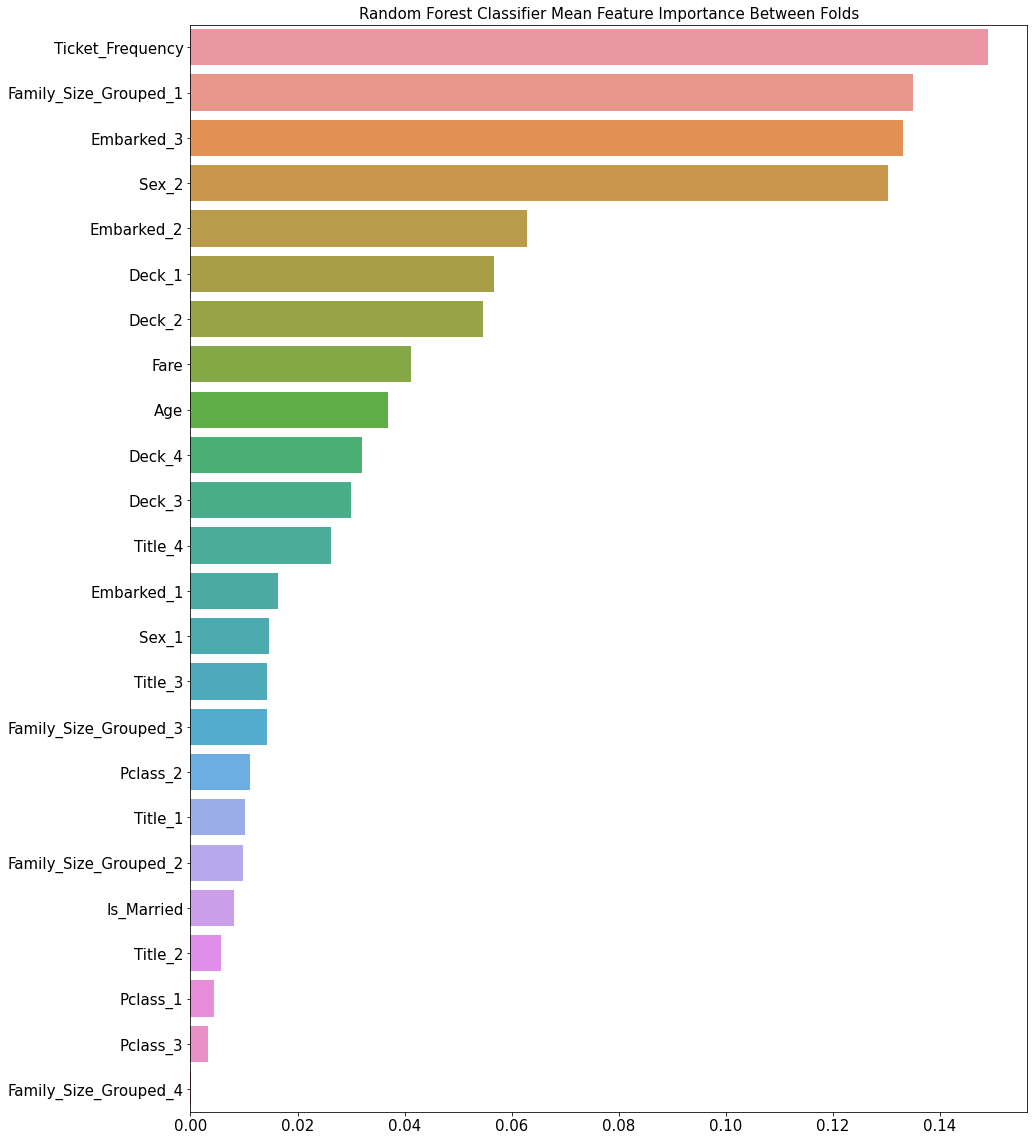

In [52]:
importances['Mean_Importance'] = importances.mean(axis=1)
importances.sort_values(by='Mean_Importance', inplace=True, ascending=False)

plt.figure(figsize=(15, 20))
sns.barplot(x='Mean_Importance', y=importances.index, data=importances)

plt.xlabel('')
plt.tick_params(axis='x', labelsize=15)
plt.tick_params(axis='y', labelsize=15)
plt.title('Random Forest Classifier Mean Feature Importance Between Folds', size=15)

plt.show()

#### ROC Curve

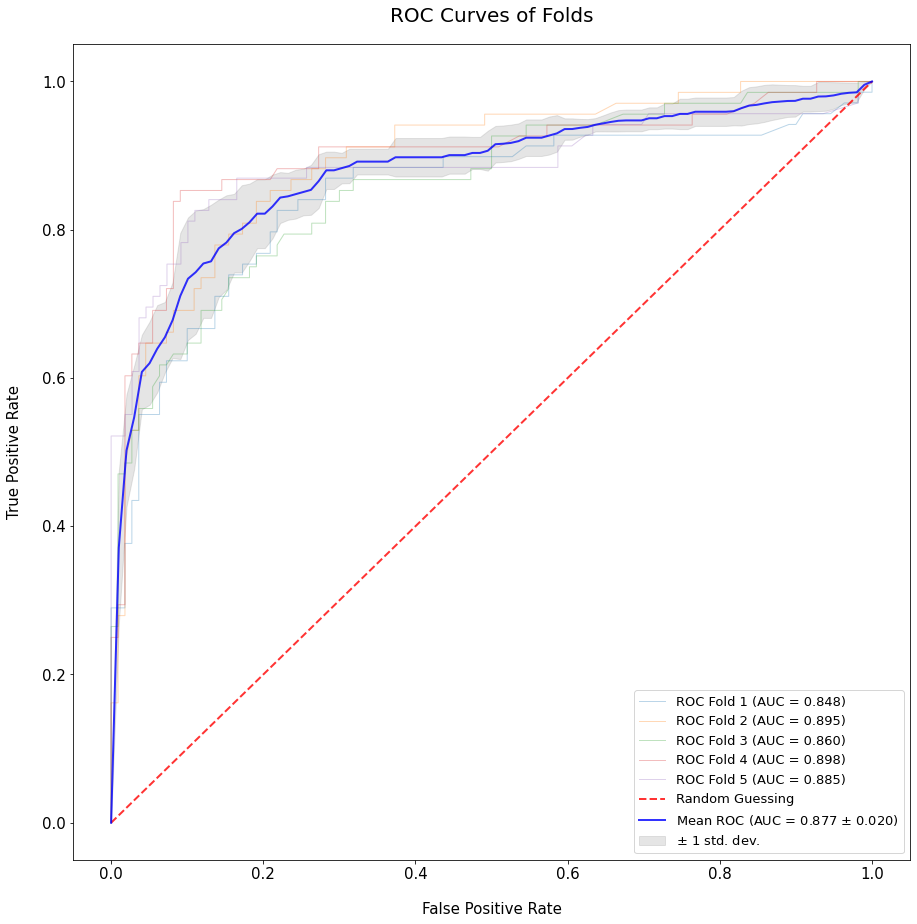

In [53]:
def plot_roc_curve(fprs, tprs):
    
    tprs_interp = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)
    f, ax = plt.subplots(figsize=(15, 15))
    
    # Plotting ROC for each fold and computing AUC scores
    for i, (fpr, tpr) in enumerate(zip(fprs, tprs), 1):
        tprs_interp.append(np.interp(mean_fpr, fpr, tpr))
        tprs_interp[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        ax.plot(fpr, tpr, lw=1, alpha=0.3, label='ROC Fold {} (AUC = {:.3f})'.format(i, roc_auc))
        
    # Plotting ROC for random guessing
    plt.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', alpha=0.8, label='Random Guessing')
    
    mean_tpr = np.mean(tprs_interp, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    
    # Plotting the mean ROC
    ax.plot(mean_fpr, mean_tpr, color='b', label='Mean ROC (AUC = {:.3f} $\pm$ {:.3f})'.format(mean_auc, std_auc), lw=2, alpha=0.8)
    
    # Plotting the standard deviation around the mean ROC Curve
    std_tpr = np.std(tprs_interp, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2, label='$\pm$ 1 std. dev.')
    
    ax.set_xlabel('False Positive Rate', size=15, labelpad=20)
    ax.set_ylabel('True Positive Rate', size=15, labelpad=20)
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])

    ax.set_title('ROC Curves of Folds', size=20, y=1.02)
    ax.legend(loc='lower right', prop={'size': 13})
    
    plt.show()

plot_roc_curve(fprs, tprs)

#### Submission

In [54]:
class_survived = [col for col in probs.columns if col.endswith('Prob_1')]
probs['1'] = probs[class_survived].sum(axis=1) / N
probs['0'] = probs.drop(columns=class_survived).sum(axis=1) / N
probs['pred'] = 0
pos = probs[probs['1'] >= 0.5].index
probs.loc[pos, 'pred'] = 1

y_pred = probs['pred'].astype(int)

submission_df = pd.DataFrame(columns=['PassengerId', 'Survived'])
submission_df['PassengerId'] = df_test['PassengerId']
submission_df['Survived'] = y_pred.values
submission_df.to_csv('submissions.csv', header=True, index=False)
submission_df.head(10)

,PassengerId,Survived
891,892,0
892,893,1
893,894,0
894,895,0
895,896,1
896,897,0
897,898,1
898,899,0
899,900,1
900,901,0
